In [1]:
%matplotlib inline
import torch 
import torchvision
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import os

In [10]:
def read_image(path):
    img = torchvision.io.read_image(path)
    return img.unsqueeze(0).float() / 255.0

def show_image(img):
    img = img.squeeze(0)
    img = img.permute(1, 2, 0)
    img = img.numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def resize_image(img, size):
    img = F.interpolate(img, size=size, mode='bilinear', align_corners=False)
    return img

def save_image(img, path):
    img = img.squeeze(0)
    img = img.permute(1, 2, 0)
    img = img.numpy()
    img = (img * 255).astype(np.uint8)
    img = torchvision.transforms.ToPILImage()(img)
    img.save(path)

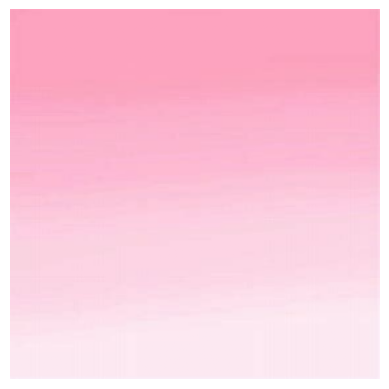

In [13]:
test_path = "/mnt/c/Users/ASUS/Documents/WPSDrive/1547059483/WPS企业云盘/清华大学/我的企业文档/instant/images/pink.jpg"

# 检查文件是否存在
if os.path.exists(test_path):
    test_img = read_image(test_path)
    test_img = resize_image(test_img, 256)
    show_image(test_img)
else:
    print(f"文件不存在: {test_path}")

In [16]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
rgb_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

def preprocess_image(image):
    return (image - rgb_mean) / rgb_std

def postprocess_image(image):
    return (image * rgb_std + rgb_mean).clamp(0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


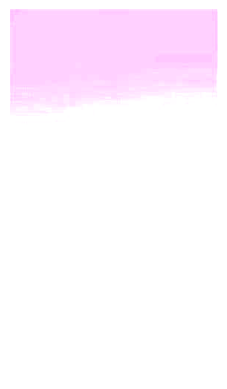

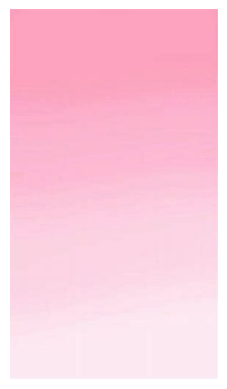

In [19]:
# test
test_img = read_image(test_path)
preprocessed_test_img = preprocess_image(test_img)
postprocessed_test_img = postprocess_image(preprocessed_test_img)
show_image(preprocessed_test_img)
show_image(postprocessed_test_img)

In [20]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

/home/huayuchen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/huayuchen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/huayuchen/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [02:01<00:00, 4.71MB/s] 


In [21]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [25]

In [22]:
net = nn.Sequential(*list(pretrained_net.features.children())[:29])

In [23]:
def extract_features(x, layer_indices):
    features = []
    for i in range(max(layer_indices) + 1):
        x = net[i](x)
        if i in layer_indices:
            features.append(x)
    return features

In [24]:
def get_content(image):
    return extract_features(image, content_layers)

def get_style(image):
    return extract_features(image, style_layers)

In [25]:
def content_loss(content, target):
    return F.mse_loss(content, target)

def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

def style_loss(style, target):
    loss = 0
    for s, t in zip(style, target):
        Gs = gram_matrix(s)
        Gt = gram_matrix(t)
        loss += F.mse_loss(Gs, Gt)
    return loss

def total_variation_loss(image):
    return F.l1_loss(image[:, :, :-1, :], image[:, :, 1:, :]) + F.l1_loss(image[:, :, :, :-1], image[:, :, :, 1:])

In [26]:
content_weight = 1.0
style_weight = 1e5
tv_weight = 2e2

In [27]:
def compute_loss(image, content, style):
    c = get_content(image)
    s = get_style(image)
    return content_weight * content_loss(c[0], content) + style_weight * style_loss(s, style) + tv_weight * total_variation_loss(image)

In [28]:
class SynthesizedImage(nn.Module):
    def __init__(self):
        super(SynthesizedImage, self).__init__()
        self.image = nn.Parameter(torch.randn(1, 3, 256, 256))
    
    def forward(self):
        return self.image

In [29]:
def init(init_img, device, lr):
    model = SynthesizedImage()
    model.image.data = init_img.clone()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return model, optimizer

In [30]:
def visualize_training_process(losses, accuracies):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'bo-', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'bo-', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def compute_acc

In [31]:
def train_and_visualize_training_process(input_image, content, style, device, epochs):
    model, optimizer = init(input_image, device, 0.1)
    train_losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = compute_loss(model(input_image.to(device)), content, style)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
    visualize_training_process(train_losses)
    return model()